<a href="https://colab.research.google.com/github/debugk/PredictPrice/blob/master/PridictPrice_EdgeConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import pandas as pd
import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
input_dir = "/content/gdrive/My Drive/PredictPrice/Input"

files   = ["COMEX_Copper_train", 
           "COMEX_Gold_train", 
           "COMEX_Palladium_train", 
           "COMEX_Platinum_train", 
           "COMEX_Silver_train", 
           "Indices_DXY Curncy_train",     # 美元指数
           "Indices_NKY Index_train",      # 日经平均指数
           "Indices_SHSZ300 Index_train",  # 沪深300
           "Indices_SPX Index_train",      # 标准普尔
           "Indices_SX5E Index_train",     # 欧元区斯托克 50 指数
           "Indices_UKX Index_train",      # 富时100指数（伦敦）
           "Indices_VIX Index_train",      # 芝加哥期权交易所市场波动率指数 -- 市场恐慌指数
           "LMEAluminium3M_train", 
           "LMECopper3M_train", 
           "LMELead3M_train", 
           "LMENickel3M_train", 
           "LMETin3M_train", 
           "LMEZinc3M_train", 
           "LMEAluminium_OI_train", 
           "LMECopper_OI_train", 
           "LMELead_OI_train", 
           "LMENickel_OI_train", 
           "LMETin_OI_train", 
           "LMEZinc_OI_train",
           "Label_LMEAluminium_train_1d", 
           "Label_LMEAluminium_train_20d", 
           "Label_LMEAluminium_train_60d", 
           "Label_LMECopper_train_1d", 
           "Label_LMECopper_train_20d", 
           "Label_LMECopper_train_60d", 
           "Label_LMELead_train_1d", 
           "Label_LMELead_train_20d", 
           "Label_LMELead_train_60d", 
           "Label_LMENickel_train_1d", 
           "Label_LMENickel_train_20d", 
           "Label_LMENickel_train_60d", 
           "Label_LMETin_train_1d", 
           "Label_LMETin_train_20d", 
           "Label_LMETin_train_60d", 
           "Label_LMEZinc_train_1d", 
           "Label_LMEZinc_train_20d", 
           "Label_LMEZinc_train_60d"]


df_dict = {}

for file_name in files:
    df_dict[file_name] = pd.read_csv("%s/Train/Train_data/%s.csv"%(input_dir, file_name), parse_dates=True,  index_col=1)


# 1. 训练
## 1.1 准备输入

In [64]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled_dict = {}
all_dates =  pd.date_range('2003/01/01', '2018/01/01', freq=pd.tseries.offsets.BDay())

for file_name in files:
  print(file_name)
  # 标准化输入数据
  scaled_data = scaler.fit_transform(df_dict[file_name].drop('Unnamed: 0', 1).values)
  df_scaled_dict[file_name] = pd.DataFrame(scaled_data, index=df_dict[file_name].drop('Unnamed: 0', 1).index, columns=df_dict[file_name].drop('Unnamed: 0', 1).columns)
  df_scaled_dict[file_name] = df_scaled_dict[file_name].reindex(all_dates)

  # 填充缺失数据
  df_scaled_dict[file_name].fillna(method='ffill', inplace=True) # 按前一天数据填充缺失值
  df_scaled_dict[file_name].fillna(0, inplace=True) # 如果数据从一开始就缺失，填0

  print(df_scaled_dict[file_name].head(n=2))

COMEX_Copper_train
                Open  High  Low  Close   Volume  Open.Interest
2003-01-01  0.000636   0.0  0.0    0.0  0.04683       0.126935
2003-01-02  0.000636   0.0  0.0    0.0  0.04683       0.126935
COMEX_Gold_train
                Open      High       Low     Close   Volume  Open.Interest
2003-01-01  0.013943  0.015315  0.014202  0.016564  0.03285       0.281507
2003-01-02  0.013943  0.015315  0.014202  0.016564  0.03285       0.281507
COMEX_Palladium_train
            Open  High  Low  Close  Volume  Open.Interest
2003-01-01   0.0   0.0  0.0    0.0     0.0            0.0
2003-01-02   0.0   0.0  0.0    0.0     0.0            0.0
COMEX_Platinum_train
            Open  High  Low     Close  Volume  Open.Interest
2003-01-01   0.0   0.0  0.0  0.000178     0.0            0.0
2003-01-02   0.0   0.0  0.0  0.000178     0.0            0.0
COMEX_Silver_train
            Open  High  Low     Close   Volume  Open.Interest
2003-01-01   0.0   0.0  0.0  0.010374  0.07193       0.314398
2003-01

In [0]:
# 合并个别输入文件
indices_names = ["Indices_DXY Curncy_train",     # 美元指数
                 "Indices_NKY Index_train",      # 日经平均指数
                 "Indices_SHSZ300 Index_train",  # 沪深300
                 "Indices_SPX Index_train",      # 标准普尔
                 "Indices_SX5E Index_train",     # 欧元区斯托克 50 指数
                 "Indices_UKX Index_train",      # 富时100指数（伦敦）
                 "Indices_VIX Index_train",      # 芝加哥期权交易所市场波动率指数 -- 市场恐慌指数
                 ]

indices_list = [df_scaled_dict[name] for name in indices_names]

df_scaled_dict['Indices_all'] = pd.concat(indices_list, axis=1)
df_scaled_dict['Indices_all'].fillna(method='ffill', inplace=True)
df_scaled_dict['Indices_all'].fillna(0, inplace=True)

In [66]:
# 合并个别输入文件
IO_names = ["LMEAluminium_OI_train", 
            "LMECopper_OI_train", 
            "LMELead_OI_train", 
            "LMENickel_OI_train", 
            "LMETin_OI_train", 
            "LMEZinc_OI_train",
            ]

IO_list = [df_scaled_dict[name] for name in IO_names]

df_scaled_dict['IO_all'] = pd.concat(IO_list, axis=1)
df_scaled_dict['IO_all'].fillna(method='ffill', inplace=True)
df_scaled_dict['IO_all'].fillna(0, inplace=True)
print(df_scaled_dict['IO_all'].head())

            LMAHDS03  LMCADS03  LMPBDS03  LMNIDS03  LMSNDS03  LMZSDS03
2003-01-01       0.0       0.0       0.0       0.0       0.0       0.0
2003-01-02       0.0       0.0       0.0       0.0       0.0       0.0
2003-01-03       0.0       0.0       0.0       0.0       0.0       0.0
2003-01-06       0.0       0.0       0.0       0.0       0.0       0.0
2003-01-07       0.0       0.0       0.0       0.0       0.0       0.0


In [0]:
# 整理label 
label_1d_names = ["Label_LMEAluminium_train_1d", 
                  "Label_LMECopper_train_1d", 
                  "Label_LMELead_train_1d", 
                  "Label_LMENickel_train_1d", 
                  "Label_LMETin_train_1d", 
                  "Label_LMEZinc_train_1d", 
                  ]

label_1d_list = [df_dict[name].drop('Unnamed: 0', 1) for name in label_1d_names]

Y_label_1d_df = pd.concat(label_1d_list, axis=1)

In [0]:
comex = ["COMEX_Copper_train", 
         "COMEX_Gold_train", 
         "COMEX_Palladium_train", 
         "COMEX_Platinum_train", 
         "COMEX_Silver_train"]

lme   = ["LMEAluminium3M_train", 
         "LMECopper3M_train", 
         "LMELead3M_train", 
         "LMENickel3M_train", 
         "LMETin3M_train", 
         "LMEZinc3M_train", ]

comex_lme_names = comex + lme
dict_names      = comex + lme + ["Indices_all", "IO_all"]

#
# 将comex，lme数据 看作一个类型，补全lme 缺少的变量OI
#
for name in lme:
  df_scaled_dict[name]["Open.Interest"] = 0

# 
# 加入percentage change
#
pct_data = {}
for name in comex:
  df_scaled_dict[name]["pct"] = df_scaled_dict[name]["Close"].pct_change().replace([np.inf, -np.inf], np.nan) # 如果头一天是0，则第二天的pct 则会是无穷大，需要去掉
  pct_data[name] = df_scaled_dict[name]["pct"].values

for name in lme:
  df_scaled_dict[name]["pct"] = df_scaled_dict[name]["Close.Price"].pct_change().replace([np.inf, -np.inf], np.nan)
  pct_data[name] = df_scaled_dict[name]["pct"].values

#
# 给cmoex 和 lme 的全部11个期货进行手动one-hot 编码
#
for i in range(len(comex_lme_names)):
  name = comex_lme_names[i]
  one_hot = np.eye(len(comex_lme_names))[i]
  df_scaled_dict[name][comex_lme_names] = pd.DataFrame(np.tile(one_hot, (len(df_scaled_dict[name]), 1)), index=df_scaled_dict[name].index)


In [69]:
# pct data
pct_data_df = pd.DataFrame(pct_data, columns=comex_lme_names).fillna(method='ffill').fillna(0)
pct_data_df.corr()

,COMEX_Copper_train,COMEX_Gold_train,COMEX_Palladium_train,COMEX_Platinum_train,COMEX_Silver_train,LMEAluminium3M_train,LMECopper3M_train,LMELead3M_train,LMENickel3M_train,LMETin3M_train,LMEZinc3M_train
COMEX_Copper_train,1.000000,-0.000706,0.052190,0.037097,0.079953,-0.001286,0.137570,0.052416,-0.096856,-0.115510,0.125351
COMEX_Gold_train,-0.000706,1.000000,0.019325,0.006485,0.186127,-0.029630,-0.037961,0.000948,-0.059637,-0.077068,-0.030014
COMEX_Palladium_train,0.052190,0.019325,1.000000,0.021446,0.052537,-0.012055,-0.001733,0.001039,-0.043372,0.004272,-0.001177
COMEX_Platinum_train,0.037097,0.006485,0.021446,1.000000,0.054399,-0.008870,0.287959,0.056230,-0.146339,-0.010868,0.026283
COMEX_Silver_train,0.079953,0.186127,0.052537,0.054399,1.000000,-0.019069,-0.022801,-0.042034,-0.032020,-0.012914,-0.017164
LMEAluminium3M_train,-0.001286,-0.029630,-0.012055,-0.008870,-0.019069,1.000000,0.261511,0.181700,0.317101,0.178532,0.304839
LMECopper3M_train,0.137570,-0.037961,-0.001733,0.287959,-0.022801,0.261511,1.000000,0.525364,0.234393,0.287124,0.716751
LMELead3M_train,0.052416,0.000948,0.001039,0.056230,-0.042034,0.181700,0.525364,1.000000,0.214336,0.175759,0.563805
LMENickel3M_train,-0.096856,-0.059637,-0.043372,-0.146339,-0.032020,0.317101,0.234393,0.214336,1.000000,0.299473,0.309775
LMETin3M_train,-0.115510,-0.077068,0.004272,-0.010868,-0.012914,0.178532,0.287124,0.175759,0.299473,1.000000,0.265375


In [0]:
def getXTrain(df, enddate, periods):
  # 得到期货的数据；选择时间段从（enddate - periods) 到 enddate 之间到工作日 
  dates =  pd.date_range(end=enddate, periods=periods, freq=pd.tseries.offsets.BDay())
  out_list = df.reindex(dates).fillna(method='ffill').fillna(0).values

  return out_list

#======================================================================================
def getXTrainPCT(df_dict, enddate, periods):
  # 为得到给定时间范围内得到协方差矩阵
  dates =  pd.date_range(end=enddate, periods=periods, freq=pd.tseries.offsets.BDay())
   
  pct_data_dict = {}

  for name in df_dict.keys():
    pct_data_dict[name] = df_dict[name].reindex(dates).fillna(method='ffill').fillna(0)['pct'].values

  pct_data_df = pd.DataFrame(pct_data_dict, columns=df_dict.keys()).fillna(method='ffill').fillna(0)
  return pct_data_df.corr().fillna(0).values
  

In [71]:
for idx, channel in enumerate((1, 2, 3)):
  print(idx, channel)

0 1
1 2
2 3


In [0]:
X_train_dict = {}
n_period     = 35

for dict_name in dict_names:
  x_train_date_list = []

  for enddate in Y_label_1d_df.index.values:
    x_train_date_list += [getXTrain(df_scaled_dict[dict_name], enddate, n_period)]
  
  X_train_dict[dict_name] = np.array(x_train_date_list)


In [13]:
# 
# 期货之间给定时间范围的的协方差矩阵
# 
select_dict = {name: df_scaled_dict[name] for name in comex_lme_names}#

x_train_pct_corr_list = []#

for enddate in Y_label_1d_df.index.values:
  x_train_pct_corr_list += [getXTrainPCT(select_dict, enddate, n_period)]#

x_train_pct_corr = np.array(x_train_pct_corr_list)

x_train_pct_corr.shape

(3790, 11, 11)

In [73]:
x_train_pct_corr.shape

(3790, 11, 11)

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
# 不要同时用keras 和 tf.keras
# keras loss 和 tf.keras loss acc 不一样？？ -- https://github.com/tensorflow/tensorflow/issues/15831

#======================================================================================================        
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

#======================================================================================================        
# A shape is (N, P_A, C), B shape is (N, P_B, C)
# D shape is (N, P_A, P_B)
def batch_distance_matrix_general(A, B): 
    with tf.name_scope('dmat'):
        r_A = tf.reduce_sum(A * A, axis=2, keepdims=True)
        r_B = tf.reduce_sum(B * B, axis=2, keepdims=True)
        m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
        D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1)) 
        return D

#======================================================================================================        
def knn(num_points, k, topk_indices, features):
    ''' prepare the tensor with selected indices from knn'''
    # topk_indices: (N, P, K)
    # features: (N, P, C)
    # out: (N, P, K, C)
    with tf.name_scope('knn'):
        queries_shape = tf.shape(features)
        batch_size = queries_shape[0]
        batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, num_points, k, 1))  
        indices = tf.concat([batch_indices, tf.expand_dims(topk_indices, axis=3)], axis=3)  # (N, P, K, 2)
        return tf.gather_nd(features, indices)

#======================================================================================================        
def edge_conv(distance, features, num_points, K, channels, with_bn=True, activation='relu', pooling='max', name='edgeconv', do_weight=False):
    """EdgeConv
    based on model below
    https://github.com/hqucms/ParticleNet.git
    Args:
        K: int, number of neighbors
        C, in_channels: # of input channels
        C, channels: tuple of output channels
        pooling: pooling method ('max' or 'average')
    Inputs:
        distance: (N, P, P)
        features: (N, P, C_0)
    Returns:
        transformed points: (N, P, C_out), C_out = channels[-1]
    """

    with tf.name_scope('edgeconv'):
        # distance
        # use covariance as distance between the points at first
        values, indices = tf.nn.top_k(-distance, k=K + 1)  # (N, P, K+1)
        indices = indices[:, :, 1:]  # (N, P, K), remove the point itself
        values  = values [:, :, 1:]  # (N, P, K)

        fts = features # (N, P, C)
        C   = tf.shape(features)[2]
        knn_fts = knn(num_points, K, indices, fts)  # (N, P, K, C )
        knn_fts_center = tf.tile(tf.expand_dims(fts, axis=2), (1, 1, K, 1))  # (N, P, K, C)
       
        # apply weight: distance[i, j]*(P[i] - P[j])
        if do_weight:
            weights      = tf.tile(tf.expand_dims(values, axis=3), (1, 1, 1, C))  # (N, P, K, C)
            knn_fts_diff = tf.multiply(tf.subtract(knn_fts, knn_fts_center), weights)
        else:
            knn_fts_diff = tf.subtract(knn_fts, knn_fts_center)

        knn_fts = tf.concat([knn_fts_center, knn_fts_diff], axis=-1)  # (N, P, K, 2*C)

        x = knn_fts
        for idx, channel in enumerate(channels):
            x = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=1, data_format='channels_last',
                                    use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_conv%d' % (name, idx))(x)
            if with_bn:
                x = keras.layers.BatchNormalization(name='%s_bn%d' % (name, idx))(x)
            if activation:
                x = keras.layers.Activation(activation, name='%s_act%d' % (name, idx))(x)

        if pooling == 'max':
            fts = tf.reduce_max(x, axis=2)  # (N, P, C')
        else:
            fts = tf.reduce_mean(x, axis=2)  # (N, P, C')

        # shortcut
        sc = keras.layers.Conv2D(channels[-1], kernel_size=(1, 1), strides=1, data_format='channels_last',
                                 use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_sc_conv' % name)(tf.expand_dims(features, axis=2))
        if with_bn:
            sc = keras.layers.BatchNormalization(name='%s_sc_bn' % name)(sc)
        sc = tf.squeeze(sc, axis=2)

        if activation:
            return keras.layers.Activation(activation, name='%s_sc_act' % name)(sc + fts)  # (N, P, C')
        else:
            return sc + fts

#======================================================================================================        
def trainRNN(comex_lme_list, pct_corr, indices, IO, Y_labels):

  #n_cate = 1
  n_cate = Y_labels.shape[1]

  #
  # comex_lme RNN model
  #
  n_hidden_comex_lme = 50
  n_conv_filters     = 4
  comex_lme_periods  = comex_lme_list[0].shape[1]
  comex_lme_features = comex_lme_list[0].shape[2]
  
  input_comex_lme  = keras.layers.Input(shape=(comex_lme_periods, comex_lme_features))
  #masked_comex_lme = keras.layers.Masking()(input_comex_lme)
  # 对每个channel做卷积，增加非线性，减少参数; PS, 后来发现在RNN中这么操作好像并没有减少很多参数
  conv_comex_lme   = keras.layers.Conv1D(n_conv_filters, kernel_size=1, strides=1, activation='relu', name='conv_lstm_comex_lme')(input_comex_lme)
  lstm_comex_lme   = LSTM(n_hidden_comex_lme, return_sequences=False)(conv_comex_lme)
  comex_lme_model  = keras.models.Model(inputs=input_comex_lme, outputs=lstm_comex_lme, name='lstm_comex_lme')

  # feed inputs
  lstm_comex_lme_outs = []
  lstm_comex_lme_inps = []
   
  for i in range(len(comex_lme_list)):
      lstm_comex_lme_inps += [Input(shape=(comex_lme_periods, comex_lme_features))]
      # 增加维度，方便后面融合
      lstm_comex_lme_outs += [keras.layers.Reshape((1, n_hidden_comex_lme))(comex_lme_model(lstm_comex_lme_inps[-1]))] 
  
  merged_comex_lme = keras.layers.concatenate(lstm_comex_lme_outs, axis=1) # (N, P, C), P == len(comex_lme_list)

  #
  # EdgeConv model
  # 
  channels = (32, 32, 32) 
  n_points = len(comex_lme_list)
  distance_input = keras.layers.Input(shape=(pct_corr.shape[1], pct_corr.shape[2]), name="Distance_corr") 
  edgeconv_out = edge_conv(-distance_input, merged_comex_lme, n_points, n_points-1, channels, do_weight=True)
  #pool = keras.layers.Bidirectional(LSTM(100, return_sequences=False), merge_mode='concat', weights=None)(merged_comex_lme)

  pool            = tf.reduce_max(edgeconv_out, axis=1) # tf.keras 可以用
  #pool            = tf.reduce_mean(edgeconv_out, axis=1) # tf.keras 可以用
  #pool            = keras.layers.Reshape((channels[-1], ))(keras.layers.MaxPool1D(pool_size=n_points, strides=1)(edgeconv_out)) 
  comex_lme_dpt   = keras.layers.Dropout(0.2)(pool)
  comex_lme_dense = Dense(32, activation='relu')(comex_lme_dpt)
  
  #
  # Other models
  # 
  input_indices  = keras.layers.Input(shape=(indices.shape[1], indices.shape[2]))
  #masked_indices = keras.layers.Masking()(input_indices)
  #lstm_indices   = LSTM(40, return_sequences=False)(masked_indices)
  lstm_indices   = LSTM(40, return_sequences=False)(input_indices)

  input_IO  = keras.layers.Input(shape=(IO.shape[1], IO.shape[2]))
  #masked_IO = keras.layers.Masking()(input_IO)
  #lstm_IO   = LSTM(40, return_sequences=False)(masked_IO)
  lstm_IO   = LSTM(40, return_sequences=False)(input_IO)

  # Dropout and merge
  merged_all = keras.layers.concatenate([comex_lme_dense, lstm_indices, lstm_IO])

  dpt1 = keras.layers.Dropout(0.3)(merged_all)
  fc1 = keras.layers.Dense(40, activation='relu')(dpt1)
  dpt2 = keras.layers.Dropout(0.3)(fc1)
  fc2 = keras.layers.Dense(40, activation='relu')(dpt2)

  output = keras.layers.Dense(n_cate, activation='sigmoid', name="signal")(fc2)

  model_inp = lstm_comex_lme_inps + [distance_input, input_indices, input_IO]
  model = keras.models.Model(inputs=model_inp, outputs=output)
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE), optimizer=keras.optimizers.Adam(), metrics=[tf.keras.metrics.BinaryAccuracy()])
  #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc']) 

  print(model.summary())
  history = LossHistory()
  
  fhist = model.fit(comex_lme_list + [pct_corr, indices, IO],
                    Y_labels,
                    validation_split=0.1,
                    epochs=30,
                    #validation_data=(test_sets, test_labels),
                    batch_size=512,
                    )
                    #callbacks=[history])
  
  keras.utils.plot_model(model, show_shapes=True)
  return model
    

# 4.2 测试

In [85]:
comex_lme_list = [X_train_dict[dict_name] for dict_name in comex_lme_names]

model = trainRNN(comex_lme_list, x_train_pct_corr, X_train_dict["Indices_all"], X_train_dict["IO_all"],  Y_label_1d_df.values)
#model = trainRNN(comex_lme_list, x_train_pct_corr, X_train_dict["Indices_all"], X_train_dict["IO_all"],  Y_label_1d_df.values[:, 1])

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_334 (InputLayer)          [(None, 35, 18)]     0                                            
__________________________________________________________________________________________________
input_335 (InputLayer)          [(None, 35, 18)]     0                                            
__________________________________________________________________________________________________
input_336 (InputLayer)          [(None, 35, 18)]     0                                            
__________________________________________________________________________________________________
input_337 (InputLayer)          [(None, 35, 18)]     0                                            
___________________________________________________________________________________________

In [55]:
print(tf.__version__)

2.2.0


In [50]:
print(tf.keras.__version__)

2.3.0-tf


In [96]:
print(keras.__version__)

2.3.0-tf


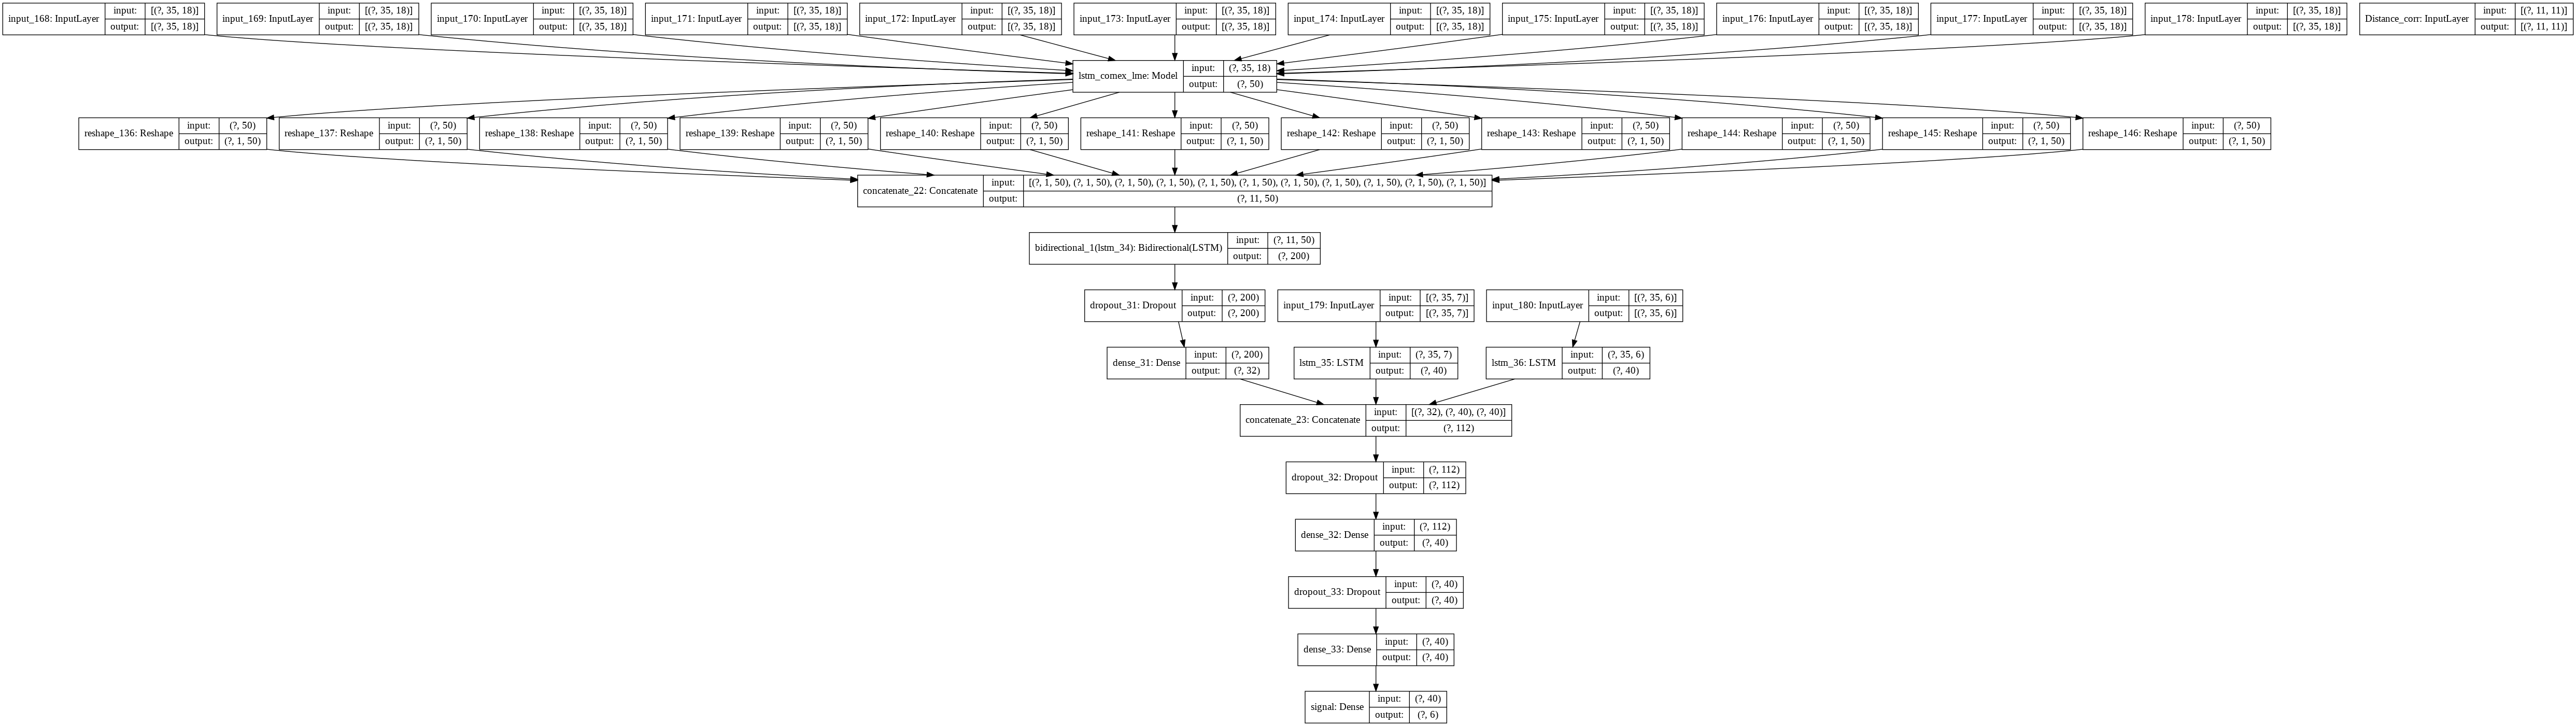

In [45]:
keras.utils.plot_model(model, show_shapes=True)